# Blenderflow

## combining tensorflow Pix2Pix and blender to create  a ML teaxturing pipeline

    Basic procedure:
    
* Import object and apply vertex colour material.
* Render out animation with Eevee 
* Pass renders through the trained Pi2Pix generator.
* Import generated textures to blender.
* Apply generated texture shader to the object, which projects the texture onto the objects.
* Render out the animation with the script that animates the generated textures.


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

import Pix_Utils

In [2]:
import os
import bpy
import Render_Utils as blnd

### Import the trained model

In [3]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('Texture_Generator.h5')

# Show the model architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 256, 32) 1536        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128, 128, 64) 33024       sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64, 64, 128)  131584      sequential_1[0][0]               
______________________________________________________________________________________________

In [12]:
PATH = './' 
true_height,true_width=512,512

In [17]:
def export_figure_matplotlib(image, f_name, dpi=400, resize_fact=1, plt_show=False):
    
    image = tf.image.resize(image, [true_height,true_width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    
    fig = plt.figure(frameon=True)
    fig.set_size_inches(image.shape[1]/dpi, image.shape[0]/dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(image)
    plt.savefig(f_name, dpi=(dpi * resize_fact))
    if plt_show:
        plt.show()
    else:
        plt.close()

## Render out textures

Tensor("strided_slice:0", shape=(512, None), dtype=float32)
Tensor("strided_slice_1:0", shape=(512, None), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


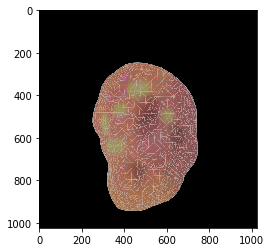

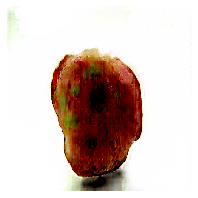

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [19]:


#blnd.render_section('./')  

inp  = Pix_Utils.load(PATH+'renderImages/'+str(bpy.data.scenes['Scene'].frame_start).zfill(5)+'.jpg')
true_height,true_width= (inp.shape[0],inp.shape[1]) 
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)


test_dataset = tf.data.Dataset.list_files(PATH+'renderImages/*.jpg', shuffle=False)
test_dataset = test_dataset.map(Pix_Utils.load_image_test)
test_dataset = test_dataset.batch(1)

for n, example_input  in enumerate(test_dataset):
    gen_output = new_model( example_input , training=True)
#print((gen_output[0] * 0.5) + 0.5)
    if n ==0:
        export_figure_matplotlib(gen_output[0], './generated/'+str(n).zfill(5)+'.png', plt_show=True)
    else:
        export_figure_matplotlib(gen_output[0], './generated/'+str(n).zfill(5)+'.png')

Tensor("strided_slice:0", shape=(512, None), dtype=float32)
Tensor("strided_slice_1:0", shape=(512, None), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


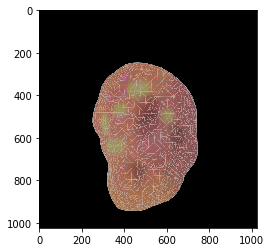

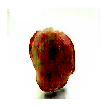

In [16]:
create_textures()

In [24]:
def render_Generated():
    
    bpy.context.scene.render.engine = 'CYCLES'
    
    
    for ob in bpy.context.scene.objects:
            if ob.type == 'MESH':
                
                material = bpy.data.materials.get("generated_texture")
   
                # Assign it to object
                if ob.data.materials:
                    # assign to 1st material slot
                    ob.data.materials[0] = material
                else:
                    # no slots
                    ob.data.materials.append(material)
    
    blnd.render_section( PATH , anim_texture = True)
    


In [ ]:
render_Generated()

In [22]:
bpy.context.scene.frame_set(100)

In [26]:
new_img = bpy.data.images.load(filepath = './generated/00001.png')

gen_material = bpy.data.materials.get("generated_texture")
nodes = [n for n in gen_material.node_tree.nodes if n.type == 'TEX_IMAGE']
for node in nodes:
    node.image = new_img
